In [1]:
import tensorflow as tf
import numpy as np
import scipy
import pandas as pd
import sklearn
from tqdm import tqdm as tqdm
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division, print_function, unicode_literals
import graph

%load_ext autoreload
%autoreload 1

ModuleNotFoundError: No module named 'tqdm'

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
header = ['Timestamp', 'Station','District', 'Freeway', 'Direction of Travel', 'Lane Type', 'Station Length',
          'Samples', '% Observed', 'Total Flow', 'Avg Occupancy', 'Avg Speed', 
          'Lane 1 Samples', 'Lane 1 Flow', 'Lane 1 Avg Occ', 'Lane 1 Avg Speed', 'Lane 1 Observed',
          'Lane 2 Samples', 'Lane 2 Flow', 'Lane 2 Avg Occ', 'Lane 2 Avg Speed', 'Lane 2 Observed',
          'Lane 3 Samples', 'Lane 3 Flow', 'Lane 3 Avg Occ', 'Lane 3 Avg Speed', 'Lane 3 Observed',
          'Lane 4 Samples', 'Lane 4 Flow', 'Lane 4 Avg Occ', 'Lane 4 Avg Speed', 'Lane 4 Observed',
          'Lane 5 Samples', 'Lane 5 Flow', 'Lane 5 Avg Occ', 'Lane 5 Avg Speed', 'Lane 5 Observed',
          'Lane 6 Samples', 'Lane 6 Flow', 'Lane 6 Avg Occ', 'Lane 6 Avg Speed', 'Lane 6 Observed',
          'Lane 7 Samples', 'Lane 7 Flow', 'Lane 7 Avg Occ', 'Lane 7 Avg Speed', 'Lane 7 Observed',
          'Lane 8 Samples', 'Lane 8 Flow', 'Lane 8 Avg Occ', 'Lane 8 Avg Speed', 'Lane 8 Observed']

## Data preprocessing

In [4]:
def get_nearest_stations(lat, long, k, meta, df):
    meta['distance'] = np.sqrt((meta.Latitude - lat)**2 + (meta.Longitude - long)**2)
    nearest_meta = meta.sort_values('distance').iloc[:k,:]
    nearest_stations = df[df.Station.isin(nearest_meta.index.values)]
    mask = nearest_stations.groupby('Station').count()['Avg Speed'] > int(0.95 * df.groupby('Station').Station.count().max())
    cleaned_station_meta = nearest_meta[nearest_meta.index.isin(mask[mask].index)]
    return cleaned_station_meta

In [5]:
meta = pd.read_table("d04_text_meta_2017_09_22.txt", index_col = 0)
import glob
files = glob.glob("data/compressed/*.txt.gz")
df_list = []
for i in tqdm(range(90)):
    df_list.append(pd.read_csv(files[i], header = None, usecols=[0,1,11] ,compression='gzip'))
df = pd.concat(df_list)
df.columns = ['Timestamp', 'Station', 'Avg Speed']

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [03:30<00:00,  2.34s/it]


In [23]:
lat = (meta[meta.index == 401143].Latitude.values + meta[meta.index == 401714].Latitude.values)[0]/2
long = (meta[meta.index == 401143].Longitude.values + meta[meta.index == 401714].Longitude.values)[0]/2
new_meta = get_nearest_stations(lat, long, 100, meta, df)

df = df[df.Station.isin(new_meta.index.values)]
df.reset_index(drop = True, inplace = True)

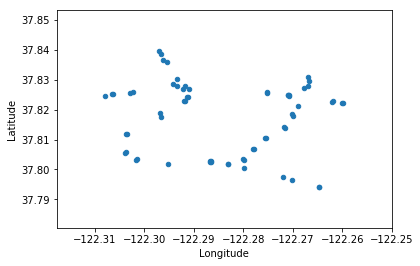

In [24]:
new_meta.plot(kind = 'scatter', x = 'Longitude', y = 'Latitude');

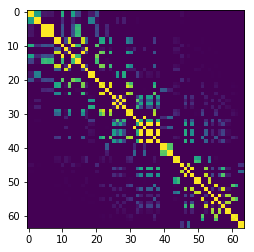

In [33]:
locations = new_meta.loc[:, ['Longitude', 'Latitude']].values
adj = graph.compute_graph(locations, gamma = 3e4)
plt.imshow(adj);

In [34]:
total_timesteps = df.groupby('Station').Station.count().max()
data = np.array(np.split(df['Avg Speed'].values, total_timesteps))
X_train, X_test = np.array_split(data, 2, axis = 0)

In [35]:
from sklearn import preprocessing
std_scaler = preprocessing.StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

# Graph construction

In [36]:
n_steps = 50
n_nodes = new_meta.shape[0]
n_inputs = 1
n_outputs = 1
n_neurons = 64

In [37]:
tf.reset_default_graph()
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

#tensorboard --logdir="C:\Users\nprok\Studies\Thesis\tf_logs"  

In [38]:
X = tf.placeholder(tf.float32, shape=[None, n_steps, n_nodes, n_inputs], name="X")
y = tf.placeholder(tf.float32, shape=[None, n_nodes, n_outputs], name="y")
#ind = tf.placeholder(tf.float32, shape=[None, n_steps, 1], name="ind")
keep_prob = tf.placeholder_with_default(1.0, shape=())
chebyshev_polynomials = tf.constant(graph.get_chebyshev_polynomials(adj, k = 4), tf.float32)\

Calculating Chebyshev polynomials up to order 4...


In [39]:
%aimport plstm
%aimport model
from plstm import PhasedLSTMCell
from model import ConvLSTMCell
use_residual = True
layers = 3


def stanh(x):
    with tf.name_scope('tanh') as scope:
        alpha = 1.5925374197228312
        return alpha * tf.nn.tanh(x)


def selu(x):
    with tf.name_scope('elu') as scope:
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        return scale * tf.where(x >= 0.0, x, alpha * tf.nn.elu(x))


XX = tf.reshape(X, [-1, n_steps, n_nodes * n_features])
# if use_input_proj:
#    XX = tf.layers.dense(XX, n_nodes*n_neurons)
cells = []
for i in range(layers):
    cell = ConvLSTMCell(n_neurons, chebyshev_polynomials=chebyshev_polynomials, use_residual_connection=use_residual,
                        activation=tf.nn.tanh)
    cell = tf.contrib.rnn.DropoutWrapper(cell, variational_recurrent=True, input_keep_prob=1, output_keep_prob=enc_keep_prob,
                                         state_keep_prob=enc_keep_prob, dtype=tf.float32)
    cells.append(cell)

cell = tf.contrib.rnn.MultiRNNCell(cells)
encoder_outputs, encoder_states = tf.nn.dynamic_rnn(cell, XX, dtype=tf.float32)

In [40]:
outputs = tf.layers.dense(rnn_outputs[:,-1], n_nodes * n_outputs)
outputs = tf.reshape(outputs, [-1, n_nodes, n_outputs])

In [41]:
with tf.variable_scope("loss"):
    error = outputs - y
    loss =  tf.reduce_mean(tf.square(error))

<tf.Tensor 'MSE:0' shape=() dtype=string>

In [42]:
learning_rate = 3e-4
max_gradient_norm = 5.  # 1 or 5
train_op = tf.contrib.layers.optimize_loss(
    loss=loss,
    global_step=tf.contrib.framework.get_global_step(),
    optimizer=tf.train.AdamOptimizer,
    learning_rate=learning_rate,
    clip_gradients=max_gradient_norm,
    name='Train')

In [44]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(logdir + '/train',  tf.get_default_graph())
test_writer = tf.summary.FileWriter(logdir + '/test')

init = tf.global_variables_initializer()
saver = tf.train.Saver()

## Training

In [ ]:
def fetch_batch(time_steps, batch_size, train = True, next_k = 1):
    if train:
        dataset = X_train
    else:
        dataset = X_test
    start_indices = np.random.randint(dataset.shape[0] - time_steps, size=batch_size)
    indices = np.array([np.arange(0,time_steps) + i for i in start_indices])
    X_batch = np.array([dataset[index] for index in indices])
    #y_batch = np.array([dataset[index + 1] for index in indices])
    if next_k == 1:
        y_batch = np.array([dataset[time_steps + i] for i in start_indices] )
        y_batch = np.expand_dims(y_batch, axis = 2)
    else:
        y_batch = np.array([[dataset[time_steps + i + j] for j in range(next_k)] for i in start_indices] )
        y_batch = np.expand_dims(y_batch, axis = 3)
    return np.expand_dims(X_batch, axis = 3),y_batch#, np.expand_dims(indices, axis = 3)

def print_variables():
    for var in tf.trainable_variables():
        print( var )

In [ ]:
batch_size = 16
n_iterations = 1000
train_keep_prob = 0.7
tst = []
from tensorflow.python.client import timeline
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = fetch_batch(n_steps, batch_size, True)
        sess.run(training_op, feed_dict ={X : X_batch, y : y_batch, keep_prob : train_keep_prob})    
        if iteration % 10 == 0 and iteration > 0: 
            X_batch, y_batch = fetch_batch(n_steps, batch_size, True)
            summary, train_loss = sess.run([merged, loss],  feed_dict ={X : X_batch, y : y_batch, keep_prob : 1})
            train_writer.add_summary(summary, iteration)
            
            X_batch, y_batch = fetch_batch(n_steps, batch_size *2, False)
            summary, test_loss, out = sess.run([merged, loss, outputs],  feed_dict ={X : X_batch, y : y_batch, keep_prob : 1})
            tst.append([y_batch, out])
            test_writer.add_summary(summary, iteration)
            print('Step %s Train loss: %s  Test loss: %s ' % (iteration, train_loss, test_loss))
        if iteration % 1000 = 999:
            save_path = saver.save(sess, "./model.ckpt")

Step 10 Train loss: 0.50066  Test loss: 0.843836 
Step 20 Train loss: 0.489357  Test loss: 1.20333 
Step 30 Train loss: 0.425539  Test loss: 0.580853 
Step 40 Train loss: 0.341674  Test loss: 0.49508 
Step 50 Train loss: 0.335826  Test loss: 0.478729 
Step 60 Train loss: 0.26898  Test loss: 0.555325 
Step 70 Train loss: 0.360129  Test loss: 0.588095 
Step 80 Train loss: 0.354093  Test loss: 0.464287 
Step 90 Train loss: 0.213845  Test loss: 0.334696 
Step 100 Train loss: 0.159602  Test loss: 0.622574 
Step 110 Train loss: 0.17795  Test loss: 0.322277 
Step 120 Train loss: 0.161723  Test loss: 0.369855 
Step 130 Train loss: 0.20603  Test loss: 0.293086 
Step 140 Train loss: 0.167681  Test loss: 0.393981 
Step 150 Train loss: 0.141409  Test loss: 0.498397 
Step 160 Train loss: 0.159291  Test loss: 0.228228 
Step 170 Train loss: 0.168293  Test loss: 0.300599 
Step 180 Train loss: 0.138368  Test loss: 0.359434 
Step 190 Train loss: 0.226457  Test loss: 0.338228 
Step 200 Train loss: 0.1681

## Evaluation

In [ ]:
def fetch_val(index, time_steps, next_k = 1):
    dataset = X_test
    indeces = np.arange(0,time_steps) + index
    X_batch = dataset[indeces]
    y_batch = np.array([dataset[time_steps + index + i ] for i in range(next_k)])
    return np.expand_dims(X_batch, axis = 2),np.expand_dims(y_batch, axis = 2)

In [ ]:
steps_ahead = 3
y_true = []
y_pred = []
with tf.Session() as sess:
    saver.restore(sess, "./model.ckpt")
    for i in range(1000, 1100):#X_test.shape[0] - shift):
        X_batch , y_batch = fetch_val(i, n_steps, steps_ahead)
        sequence = X_batch.tolist()
        output = []
        y_true.append(std_scaler.inverse_transform(np.squeeze(y_batch)))
        for j in range(steps_ahead):
            X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, n_nodes, n_inputs)
            out = sess.run(outputs, feed_dict ={X : X_batch, keep_prob : 1})  
            sequence.append(out[0])
            y_pred.append(std_scaler.inverse_transform(np.squeeze(out)))
        if (i % 10 == 0):
            print("Processing %d input" % i)
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()


In [ ]:
sklearn.metrics.mean_absolute_error(y_pred, y_true)#4 10 17

In [ ]:
sklearn.metrics.mean_squared_error(std_scaler.transform(y_pred.reshape([-1,64])), std_scaler.transform(y_true.reshape([-1,64])))

In [ ]:
np.argmax(((y_true - y_pred)**2) > 100)

In [ ]:
y_true

In [ ]:
sklearn.metrics.mean_squared_error(X_test[:-6].flatten(), X_test[6:].flatten())